Make sure everything runs as expected before you submit your notebook. First, **restart the kernel** (Kernel$\rightarrow$Restart) and then **run all cells** (Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and student ID below:

In [1]:
NAME = "Benji van den Brand"
STUDENT_ID = "1328255"

"1328255"

---

# [5SSD0] Probabilistic Programming - Assignment 1

Year: 2023-2024

In this assignment, we will go through the Bayesian model design cycle:

 <img src="figures/modelling-procedure.png" alt="" width="600"> 

You will build a simple model, fit it to data and evaluate its performance on future data. Its performance is not great and you are challenged to improve it.

In [2]:
import Pkg; Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("LinearAlgebra")
Pkg.add("ProgressMeter")
Pkg.add("RxInfer")
Pkg.add("Plots")


    Updating registry at `C:\Users\benji\.julia\registries\General.toml`


   Resolving package versions...


  No Changes to `C:\Users\benji\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\benji\.julia\environments\v1.9\Manifest.toml`

   Resolving package versions...


  No Changes to `C:\Users\benji\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\benji\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\benji\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\benji\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\benji\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\benji\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\benji\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\benji\.julia\environments\v1.9\Manifest.toml`

   Resolving package versions...


  No Changes to `C:\Users\benji\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\benji\.julia\environments\v1.9\Manifest.toml`

In [3]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

using CSV
using DataFrames
using LinearAlgebra
using Distributions
using StatsFuns
using RxInfer
using Plots
using ProgressMeter
default(label="",
        grid=false, 
        linewidth=3, 
        markersize=4,
        guidefontsize=12, 
        margins=15Plots.pt)

  Activating project at `c:\Github projects\BMLIP\lessons\assignments`


## Problem: Forecasting Air Quality

Many Europeans suspect that the air quality in their city is declining. A [recent study](https://doi.org/10.1016/j.snb.2007.09.060) measured the air quality of a major city in North Italy using an electronic nose. The measurements were made in the middle of the city and reflect urban activity. We will inspect the specific chemical concentrations found and build a model to accurately predict CO for future time points.

![https://www.theguardian.com/environment/2020/apr/07/air-pollution-linked-to-far-higher-covid-19-death-rates-study-finds](figures/air-milan-wide.png)

Photograph taken by Claudio Furlan/LaPresse/Zuma Press/Rex/Shutterstock ([link](https://www.theguardian.com/environment/2020/apr/07/air-pollution-linked-to-far-higher-covid-19-death-rates-study-finds))

### Data

The data can be found here: https://archive.ics.uci.edu/ml/datasets/Air+Quality. I've done some pre-processing and selected the most important features. In this assignment we will infer parameters in a model of the data and predict air quality in the future. For that purpose, the data has been split into past and future.

In [4]:
past_data = DataFrame(CSV.File("data/airquality_past.csv"))

Row,time,CO
,DateTime,Float64
1,2004-03-10T18:00:00,1360.0
2,2004-03-10T19:00:00,1292.0
3,2004-03-10T20:00:00,1402.0
4,2004-03-10T21:00:00,1376.0
5,2004-03-10T22:00:00,1272.0
6,2004-03-10T23:00:00,1197.0
7,2004-03-11T00:00:00,1185.0
8,2004-03-11T01:00:00,1136.0
9,2004-03-11T02:00:00,1094.0


Let's visualize the carbon monoxide measurements over time.

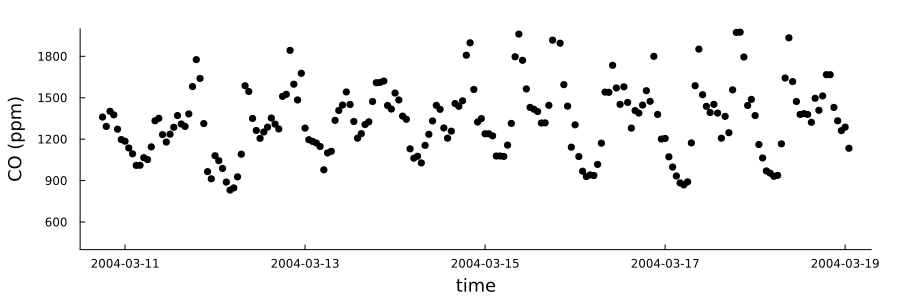

In [5]:
scatter(past_data[:,1], 
        past_data[:,2], 
        size=(900,300), 
        color="black", 
        xlabel="time", 
        ylabel="CO (ppm)",
        ylims=[400,2000])

## 1. Model specification & parameter estimation

We suspect that there is a temporal dependence in this dataset. In other words, the data changes relatively slowly over time and neighbouring data points end up being highly correlated. To exploit this correlation, we will build an _auto-regressive model_ of the form:

$$ y_k = \theta y_{k-1} + \epsilon_k \, , $$

where the noise $\epsilon_k$ is drawn from a zero-mean Gaussian with precision parameter $\tau$: 

$$ \epsilon_k \sim \mathcal{N}(0, \tau^{-1}) \, .$$

For now, we will use $\tau = 1.0$.

Tasks:
- [1pt] Specify the above equation as a probabilistic model in RxInfer, and infer a posterior distribution for $\theta$. Plot the inferred distribution over the interval $[0.9,\ 1.0]$.

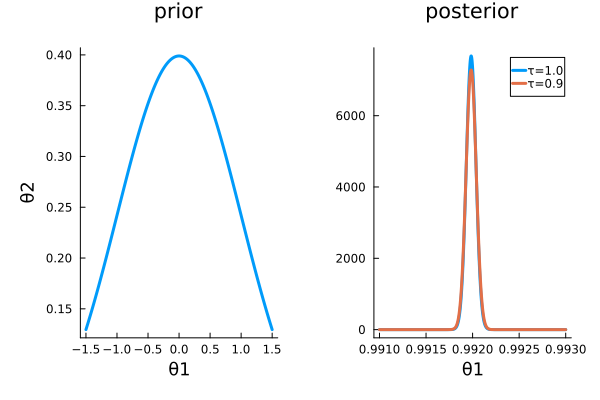

In [14]:
# YOUR CODE HERE
@model function auto_regression(μ_θ, Σ_θ, τ; N=1)
    "Bayesian linear regression"
    
    # Allocate data variables
    X = datavar(Float64, N)
    y = datavar(Float64, N)
    
    # Prior distribution of coefficients
    θ ~ NormalMeanVariance(μ_θ, Σ_θ)
    
    for i = 1:N

        # Likelihood of i-th sample
        y[i] ~ NormalMeanVariance(θ*X[i], τ^-1)
        
    end
    return y, X, θ
end

# Prior parameters
μ_θ, Σ_θ = (0, 1)

# Likelihood variance
τ = 1;
num_samples = length(past_data[:,1])
dates_num = 1:num_samples

# Call inference function
results = inference(
    model       = auto_regression(μ_θ, Σ_θ, τ, N=num_samples-1),
    data        = (y = past_data[:,2][2:num_samples], X = past_data[:,2][1:num_samples-1]),
    returnvars  = (θ = KeepLast()),
)

# Extract posterior weights 
post_θ = results.posteriors[:θ]

# Define ranges for plot
x1 = range(-1.5, length=500, stop=1.5)

# Draw contour plots of distributions
x1 = range(-1.5, step=0.01, stop=1.5)
prior_θ = Normal(μ_θ, Σ_θ)
p1a = plot(x1, pdf(prior_θ, x1), xlabel="θ1", ylabel="θ2", title="prior", label="")

x1 = range(0.991, step=0.000001, stop=0.993)
p1b = plot(x1, pdf(post_θ, x1), xlabel="θ1", title="posterior", label="τ=1.0")

τ = 0.9;
results = inference(
    model       = auto_regression(μ_θ, Σ_θ, τ, N=num_samples-1),
    data        = (y = past_data[:,2][2:num_samples], X = past_data[:,2][1:num_samples-1]),
    returnvars  = (θ = KeepLast()),
)
post_θ = results.posteriors[:θ]

p1b_2 = plot!(x1, pdf(post_θ, x1), xlabel="θ1", title="posterior", label="τ=0.9")
plot(p1a, p1b)

## 2. Predictions & model evaluation

We want to evaluate the parameters inferred under the model. For now, we will do this by visually inspecting the 1-step ahead predictions on our data set. Later, we will use free energy as a metric. 

The posterior predictive distribution for the next time step is:

$$ p(y_{k+1} \mid \bar{y}_k, \mathcal{D}) = \int p(y_{k+1} \mid \theta, \bar{y}_k) p(\theta \mid \mathcal{D}) \, \mathrm{d}\theta \, , $$

where $\mathcal{D}$ refers to the past data (used to infer the posterior distribution) and $\bar{y}$ refers to the previous $M$ data points (i.e. $\bar{y}_k = [y_{k-1} \dots y_{k-M}]$). To make 1-step ahead predictions, you will have to loop over the data (i.e., `for k in 1:T`), plug in the current data point and compute the parameters of the posterior predictive distribution for the next data point. You may start from $k=2$, using $y_1$ as initial "previous observation". 

Tasks:
- [1pt] Derive the parameters of the posterior predictive and compute the 1-step ahead predictions on the data set. Plot the first 10 predictions (_mean and 1 standard deviation_) along with the data $y_{2:11}$.

---

Note that if you failed to infer a posterior distribution in the previous question, you can still answer this question using a standard normal, $p(\theta) = \mathcal{N}(0,1)$.

Coefficient = 0.9919845346726487


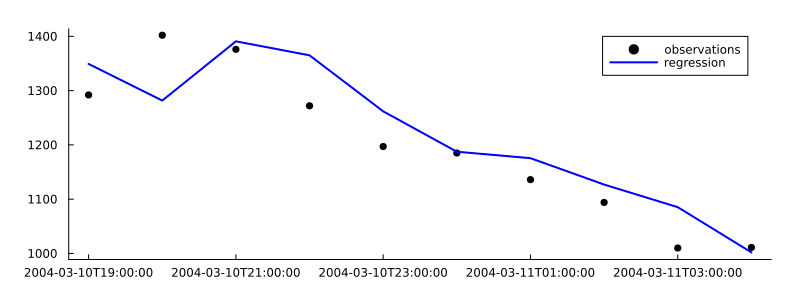

In [15]:
# YOUR CODE HERE
# Extract estimated weights
θ_MAP = mode(post_θ)
num_samples = 11

# Report results
println("Coefficient = "*string(θ_MAP))

# Make predictions
regression_estimated = past_data[:,2][1:num_samples-1] * θ_MAP;

# Visualize observations
scatter(past_data[:,1][2:num_samples], past_data[:,2][2:num_samples], color="black", label="observations", legend=:topright)

# Overlay regression function
plot!(past_data[:,1][2:num_samples], regression_estimated, ribbon=1, color="blue", label="regression", linewidth=2, size=(800,300))

## 3. Model critiqueing & improvement

From the results of the previous question, you may conclude that our initial model isn't great: it only considers extremely short-term changes, which are highly affected by noise. If we want the model to consider changes over longer periods of time, then we need to increase the order of the auto-regressive model. That corresponds to:

$$ y_k = \sum_{m=1}^{M} \theta_m y_{k-m} + \epsilon_k \, ,$$

where $M$ refers to model order.

Tasks:
- [1pt] Specify a higher-order AR model with an order parameter $M$, and with an appropriate prior on the AR coefficients. Visualize the 1-step ahead predictions (_mean and variance_) on the data.

Coefficients = [0.1244163759361286, -0.4034465898203532, 1.2700795161430969]


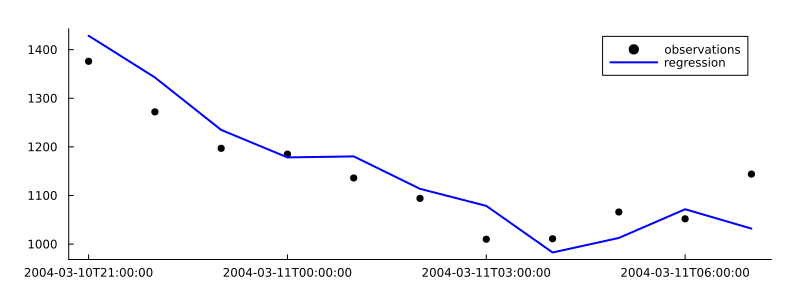

In [16]:
# YOUR CODE HERE
@model function auto_regression(μ_θ, Σ_θ, τ; N=1)
    "Bayesian linear regression"
    
    # Allocate data variables
    X = datavar(Vector{Float64}, N)
    y = datavar(Float64, N)
    
    # Prior distribution of coefficients
    θ ~ MvNormalMeanCovariance(μ_θ, Σ_θ)

    for i = 1:N

        # Likelihood of i-th sample
        y[i] ~ NormalMeanVariance(dot(θ,X[i]), τ^-1)
        
    end
    return y, X, θ
end

# Prior parameters
M = 3
μ_θ, Σ_θ = (zeros(M), diagm(ones(M)))

# Likelihood variance
τ = 1.0;
num_samples = length(past_data[:,1])
dates_num = 1:num_samples

# Call inference function
history = [[past_data[:,2][i+j] for j in 0:M-1] for i in 1:num_samples-M]
results = inference(
    model       = auto_regression(μ_θ, Σ_θ, τ, N=num_samples-M),
    data        = (y = past_data[:,2][M+1:num_samples], X = history),
    returnvars  = (θ = KeepLast()),
)

# Extract posterior weights 
post_θ = results.posteriors[:θ]

# Extract estimated weights
θ_MAP = mode(post_θ)

# Report results
println("Coefficients = "*string(θ_MAP))

# Make predictions
num_samples = 11
regression_estimated = [dot(row, θ_MAP) for row in history]

# Visualize observations
scatter(past_data[:,1][M+1:num_samples+M], past_data[:,2][M+1:num_samples+M], color="black", label="observations", legend=:topright)

# Overlay regression function
plot!(past_data[:,1][M+1:num_samples+M], regression_estimated[1:num_samples], ribbon=1, color="blue", label="regression", linewidth=2, size=(800,300))

## 4. Model selection & deployment

Every value of $M$ produces a different model. But which is the best? 

For now, we will evaluate models using a non-Bayesian criterion. The mean-squared error between the MAP solution and future data can be calculated with:

$$ \text{MSE} = \frac{1}{T} \sum_{k=1}^{T} \big(\sum_{m=1}^{M} \hat{\theta}^{\text{MAP}}_m y_{k-m} - y_{k} \big)^2 $$

Tasks:
- [1pt] Compute the mean squared errors for a range of values of $M$ (AR model order) and report the best performing one.
- [1pt] Deploy the best model on the future data (1-step ahead predictions) and visualize the predictions (_mean and 1 standard deviation_).

In [10]:
# YOUR CODE HERE

mse_lowest = Inf
M_best = 1
θ_best = 0

for M in 1:10
    μ_θ, Σ_θ = (zeros(M), diagm(ones(M)))

    # Likelihood variance
    τ = 1.0;
    num_samples = length(past_data[:,1])
    dates_num = 1:num_samples

    # Call inference function
    history = [[past_data[:,2][i+j] for j in 0:M-1] for i in 1:num_samples-M]
    results = inference(
        model       = auto_regression(μ_θ, Σ_θ, τ, N=num_samples-M),
        data        = (y = past_data[:,2][M+1:num_samples], X = history),
        returnvars  = (θ = KeepLast()),
    )

    # Extract posterior weights 
    post_θ = results.posteriors[:θ]

    # Extract estimated weights
    θ_MAP = mode(post_θ)

    # Report results
    #println("Coefficients = "*string(θ_MAP))

    # Make predictions
    num_samples = 11
    regression_estimated = [dot(row, θ_MAP) for row in history]

    error_ar = past_data[:,2][M+1:num_samples+M]-regression_estimated[1:num_samples]
    error_ar = error_ar.^2
    mse_ar = mean(error_ar)
    println("Model length: ", string(M), ", MSE: ", string(mse_ar))
    if mse_ar < mse_lowest
        mse_lowest = mse_ar
        M_best = M
        θ_best = θ_MAP
    end
end

print("Best model length: ", M_best)

Model length: 1, MSE: 3925.4239043838893
Model length: 2, MSE: 3707.0303171079186
Model length: 3, MSE: 2992.4467250258517
Model length: 4, MSE: 5832.8072979054805
Model length: 5, MSE: 5294.780797170061
Model length: 6, MSE: 5835.05670854609
Model length: 7, MSE: 5722.932908032486
Model length: 8, MSE: 5778.034323295673
Model length: 9, MSE: 5944.707563946778
Model length: 10, MSE: 5725.079444459301


Best model length: 3

In [11]:
# Load test data
future_data = DataFrame(CSV.File("data/airquality_future.csv"))

Row,time,CO
,DateTime,Float64
1,2004-03-19T02:00:00,999.0
2,2004-03-19T03:00:00,961.0
3,2004-03-19T04:00:00,934.0
4,2004-03-19T05:00:00,913.0
5,2004-03-19T06:00:00,969.0
6,2004-03-19T07:00:00,1182.0
7,2004-03-19T08:00:00,1740.0
8,2004-03-19T09:00:00,1819.0
9,2004-03-19T10:00:00,1427.0


Coefficients = [0.1244163759361286, -0.4034465898203532, 1.2700795161430969]


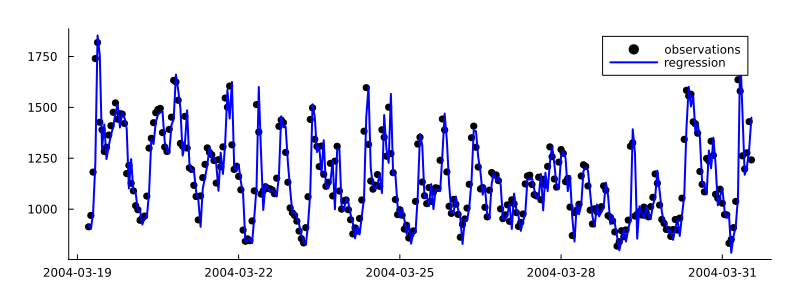

In [17]:
# YOUR CODE HERE
M = M_best
μ_θ, Σ_θ = (zeros(M), diagm(ones(M)))

# Likelihood variance
τ = 1.0;
num_samples = length(future_data[:,1])
dates_num = 1:num_samples

# Report results
println("Coefficients = "*string(θ_best))

# Make predictions
num_samples = length(future_data[:,1])
history = [[future_data[:,2][i+j] for j in 0:M-1] for i in 1:num_samples-M]
regression_estimated = [dot(row, θ_best) for row in history]

# Visualize observations
scatter(future_data[:,1][M+1:num_samples], future_data[:,2][M+1:num_samples], color="black", label="observations", legend=:topright)

# Overlay regression function
plot!(future_data[:,1][M+1:num_samples], regression_estimated[1:num_samples-M], ribbon=1, color="blue", label="regression", linewidth=2, size=(800,300))